# Two-dimensional data with bottleneck

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Create sklearn.datasets.make_moons() data sets of varying sizes

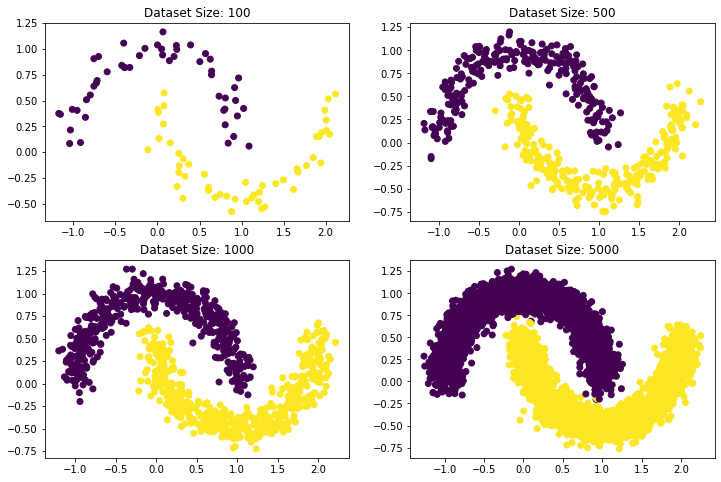

In [5]:
dataset_sizes = [100, 500, 1000, 5000]

# Generate datasets of varying sizes
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': torch.FloatTensor(X), 'y': y}

# Visualize the datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
    plt.title(f'Dataset Size: {size}')

plt.show()

Next we implement the Autoencoder class with variable length of hidden layers

In [18]:
# Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        
        encoder_layers = []
        decoder_layers = []
        
        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())

        # Encoder and Decoder layers
        for _ in range(layers):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size)) 
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        
        # Combine encoder and decoder
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Lets define the training function with the demanded parameters

In [19]:
# Training function
def train_autoencoder(model, datasets, dataset_size=1000, num_epochs=100, batch_size=64, learning_rate=0.001):
    
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Data loader
    data_loader = torch.utils.data.DataLoader(datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for batch in data_loader:
            # Forward pass
            outputs = model(batch)

            # Compute the loss
            loss = criterion(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Checking training functionality:

In [21]:
# Create and train the autoencoder
input_size = 2
bottleneck_size = 1
hidden_size = 4
layers = 2

autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size, layers)
train_autoencoder(autoencoder, datasets, dataset_size=1000,num_epochs=100)

Epoch [10/100], Loss: 0.2417
Epoch [20/100], Loss: 0.1264
Epoch [30/100], Loss: 0.0900
Epoch [40/100], Loss: 0.0890
Epoch [50/100], Loss: 0.0891
Epoch [60/100], Loss: 0.0753
Epoch [70/100], Loss: 0.0595
Epoch [80/100], Loss: 0.0752
Epoch [90/100], Loss: 0.0768
Epoch [100/100], Loss: 0.0479


The Autoencoder seems to be working and reduces the mean squared reconstruction loss